### Dependencies

You can install all the depenencies neccessary using pip. It is recommended to use a virtualenv to protect your user level python installation.


```bash
# create a virtualenv in project directory
python3 -m venv venv && source venv/bin/activate && pip install -r requirements.txt

# open notebook
python3 -m jupyter notebook notebooks/getting-started.ipynb
```

In [582]:
import os
import sys
import torch
import hashlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from abc import ABC
from tqdm import tqdm
from functools import partial
from dataclasses import dataclass
from typing import Optional
from abc import ABC
from tqdm import tqdm
from functools import partial
from dataclasses import dataclass
from typing import Optional, Any, Dict, List, Tuple

In [721]:
torch.rand((1,3,3))

tensor([[[0.1676, 0.3075, 0.5861],
         [0.4520, 0.5286, 0.4316],
         [0.2927, 0.0031, 0.2506]]])

In [724]:
torch.rand((3,3)).reshape(1, 3, 3).shape

torch.Size([1, 3, 3])

In [583]:
parent = os.path.dirname(os.getcwd())
if "notebooks" in parent:
    parent = os.path.dirname(parent)
sys.path.append(parent)

In [584]:
from common import example

# test run an import to ensure we can import
example.memoed_fib(25)

75025

In [585]:
class Metric(ABC):
    @abstractmethod
    def score(dataset, model) -> float:
        pass

@dataclass
class ExperimentParameters:
    epochs = 100
    loss = torch.nn.CrossEntropyLoss()
    optimizer = partial(torch.optim.Adam, lr=0.01, weight_decay=5e-4)
    # metrics: List[Metric]

In [586]:
# misc useful funttions
def np_to_md5(value: np.ndarray) -> str:
    return hashlib.md5(value.flatten().astype("uint8")).hexdigest()

# Baseline MNIST classifier (to be attacked)

In [587]:
KERAS_DIRECTORY = os.path.expanduser("~/.keras/datasets")
MNIST_FILEPATH = os.path.join(KERAS_DIRECTORY, "mnist.npz")

In [588]:
train, *_ = dict(np.load(MNIST_FILEPATH)).values()

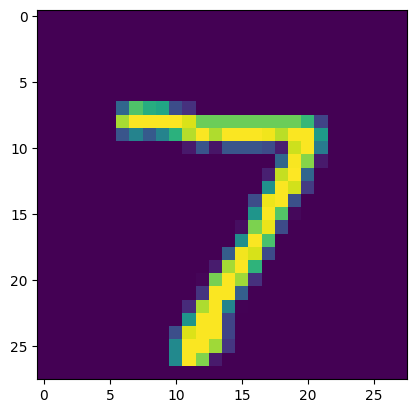

In [589]:
plt.imshow(train[0, :])

In [761]:
class InMemoryMNIST(Dataset):

    # torch conv layers require images of shape (idx, channels,    
    def __init__(self, filepath: str, test_set: bool = False):
        x_test, x_train, y_train, y_test = dict(np.load(filepath)).values()
        self.x = torch.as_tensor(x_test if test_set else x_train, dtype=torch.float32)
        self.y = torch.as_tensor(y_test if test_set else y_train, dtype=torch.float32)

        # torch conv layers require images of shape (idx, channels, width, height)
        self.x = self.x.reshape(self.x.shape[0], 1, 28, 28)
    
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx: int):
        return self.x[idx, :, :], self.y[idx]

    def loader(self, batch_size: int = 2, shuffle: bool = True) -> DataLoader:
        return DataLoader(self, shuffle=shuffle, batch_size=batch_size)

training_set = InMemoryMNIST(MNIST_FILEPATH, test_set=False).loader()
testing_set = InMemoryMNIST(MNIST_FILEPATH, test_set=True).loader()

In [762]:
class Metric(ABC):
    @abstractmethod
    def evaluate(dataset, model, *args, **kwargs) -> float:
        pass

@dataclass
class ExperimentParameters:
    epochs = 100
    model: nn.Module = BaseCNNClassifier
    loss = torch.nn.CrossEntropyLoss
    optimizer = partial(torch.optim.Adam, lr=0.01, weight_decay=5e-4)
    description: str = ""

In [771]:
class BaseCNNClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=(2, 2), stride=2)              # 28x28 -> 14x14 -> CHECKS OUT
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)                           
        self.conv2 = nn.Conv2d(1, 1, kernel_size=(2, 4), stride=2)
        
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):        
        x = self.pool1(F.relu(self.conv1(x)))
        print(x.shape)
        x = self.pool1(F.relu(self.conv2(x)))
        print(x.shape)
        x = torch.flatten(x, 1)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.softmax(self.fc2(x))
        print(x.shape)
        
        return x

In [772]:
model = BaseCNNClassifier()
model

BaseCNNClassifier(
  (conv1): Conv2d(1, 1, kernel_size=(2, 2), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 10, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)

In [773]:
def train(dataset, params: ExperimentParameters):

    model = params.model()
    opt = params.optimizer(model.parameters())
    loss_function = params.loss()

    with tqdm(range(1, params.epochs + 1), desc="epoch training loss", leave=True) as epochs:
        model.train()
        for epoch in epochs:
            for batch in training_set:
                images, labels = batch
                print(f"{images.shape=}")
                opt.zero_grad()
                prob = model(images)
                loss = loss_function(yhat.argmax(axis=1), labels)
                loss.backward()
                opt.step()
                epochs.set_description(f"{epoch=:03d}, {loss=:.4f}")

    return model

In [774]:
train(training_set, ExperimentParameters())

epoch training loss:   0%|                              | 0/100 [00:00<?, ?it/s]

images.shape=torch.Size([2, 1, 28, 28])
torch.Size([2, 1, 7, 7])
torch.Size([2, 1, 1, 1])
torch.Size([2, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1 and 10x10)